Initialize and observe how samples under ES algorithm evolves

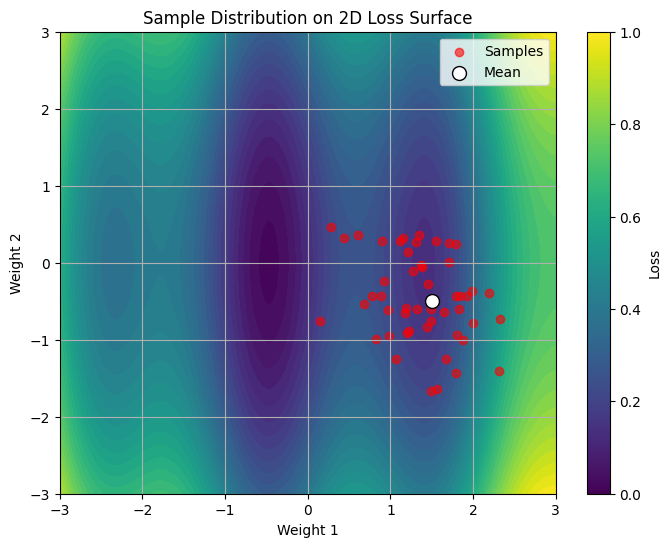

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define loss surface
def loss_fn(x, y):
    return x**2 + 0.5 * y**2 + 2 * np.sin(3 * x)

# Sampling
mean = np.array([1.5, -0.5])
std = 0.5
n_samples = 50
samples = np.random.randn(n_samples, 2) * std + mean

# Loss grid
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = loss_fn(X, Y)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.scatter(samples[:, 0], samples[:, 1], c='red', label='Samples', alpha=0.6)
plt.scatter(mean[0], mean[1], c='white', edgecolor='black', label='Mean', s=100)
plt.colorbar(label='Loss')
plt.legend()
plt.title("Sample Distribution on 2D Loss Surface")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
plt.grid(True)
plt.show()


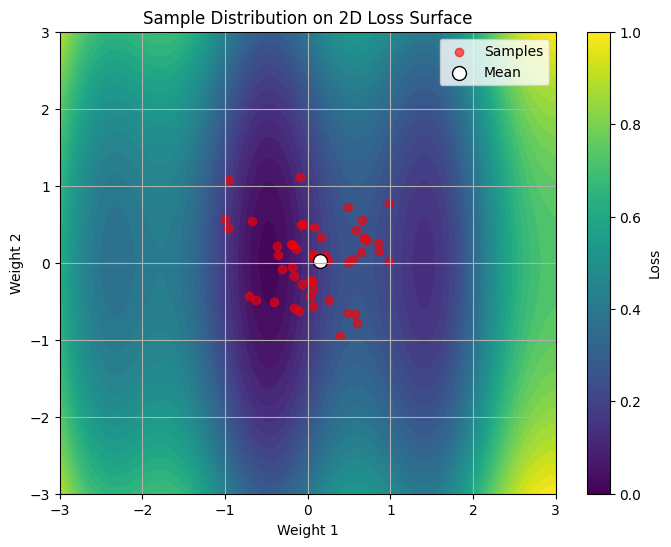

In [37]:
# ES parameter update

# Compute losses
losses = loss_fn(samples[:, 0], samples[:, 1])

# Compute log_grad and update
log_grad = (samples - mean) / std**2
norm_loss = (losses - np.mean(losses)) / (np.std(losses) + 1e-8)
grad = (log_grad.T * norm_loss).T
mean_update = grad.mean(axis=0)

# Update mean
lr = 0.1
mean = mean - lr * mean_update
std = 0.5
n_samples = 50
samples = np.random.randn(n_samples, 2) * std + mean

# Loss grid
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = loss_fn(X, Y)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.scatter(samples[:, 0], samples[:, 1], c='red', label='Samples', alpha=0.6)
plt.scatter(mean[0], mean[1], c='white', edgecolor='black', label='Mean', s=100)
plt.colorbar(label='Loss')
plt.legend()
plt.title("Sample Distribution on 2D Loss Surface")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
plt.grid(True)
plt.show()


ES VS CEM VS PSO

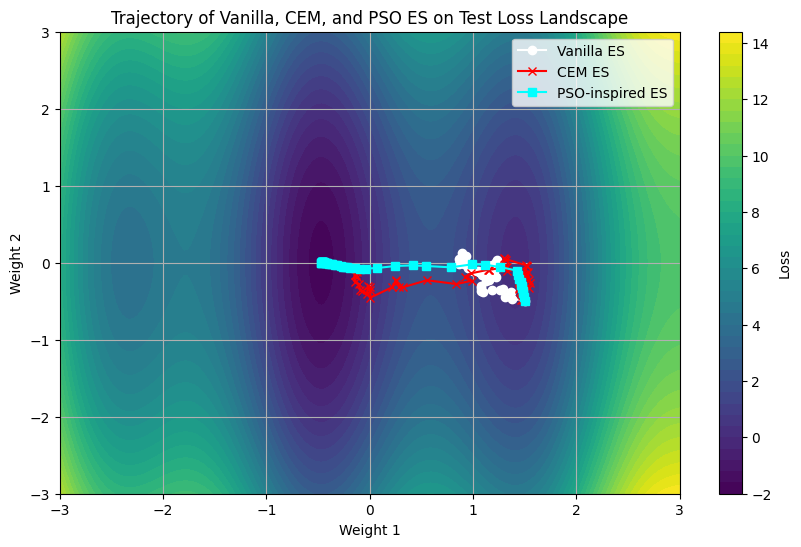

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# 2D test landscape (banana-shaped loss)
def loss_fn(x, y):
    return x**2 + 0.5 * y**2 + 2 * np.sin(3 * x)

# Evaluate vanilla, CEM, and PSO steps
def run_es_on_landscape(method="vanilla", steps=50, n_samples=50, std=0.5, lr=0.1):
    mean = np.array([1.5, -0.5])
    mean_trace = [mean.copy()]
    velocity = np.zeros_like(mean)
    personal_best = mean.copy()
    global_best = mean.copy()
    best_loss = float('inf')

    for step in range(steps):
        samples = np.random.randn(n_samples, 2) * std + mean
        losses = loss_fn(samples[:, 0], samples[:, 1])

        if method == "vanilla":
            log_grad = (samples - mean) / std**2
            norm_loss = (losses - np.mean(losses)) / (np.std(losses) + 1e-8)
            grad = (log_grad.T * norm_loss).T
            mean_update = grad.mean(axis=0)
            mean = mean - lr * mean_update

        elif method == "cem":
            top_k = int(0.2 * n_samples)
            elite_idx = np.argsort(losses)[:top_k]
            elite_samples = samples[elite_idx]
            log_grad = (elite_samples - mean) / std**2
          elite_losses = losses[elite_idx]
          norm_loss = (elite_losses - elite_losses.mean()) / (elite_losses.std() + 1e-8)
            grad = (log_grad.T * norm_loss).T
            mean_update = grad.mean(axis=0)
            mean = mean - lr * mean_update

        elif method == "pso":
            current_best_idx = np.argmin(losses)
            if losses[current_best_idx] < best_loss:
                best_loss = losses[current_best_idx]
                global_best = samples[current_best_idx].copy()
            r1, r2 = np.random.rand(2)
            velocity = 0.5 * velocity + 1.5 * r1 * (personal_best - mean) + 1.5 * r2 * (global_best - mean)
            mean = mean + lr * velocity
            personal_best = mean.copy()

        mean_trace.append(mean.copy())

    return np.array(mean_trace)

# Generate background loss surface
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = loss_fn(X, Y)

# Run all methods
trace_vanilla = run_es_on_landscape(method="vanilla")
trace_cem = run_es_on_landscape(method="cem")
trace_pso = run_es_on_landscape(method="pso")

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.plot(trace_vanilla[:, 0], trace_vanilla[:, 1], c='white', marker='o', label='Vanilla ES')
plt.plot(trace_cem[:, 0], trace_cem[:, 1], c='red', marker='x', label='CEM ES')
plt.plot(trace_pso[:, 0], trace_pso[:, 1], c='cyan', marker='s', label='PSO-inspired ES')
plt.colorbar(label='Loss')
plt.legend()
plt.title("Trajectory of Vanilla, CEM, and PSO ES on Test Loss Landscape")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
plt.grid(True)
plt.show()


ES vs cem vs cem-es vs pso vs annealing vs pool

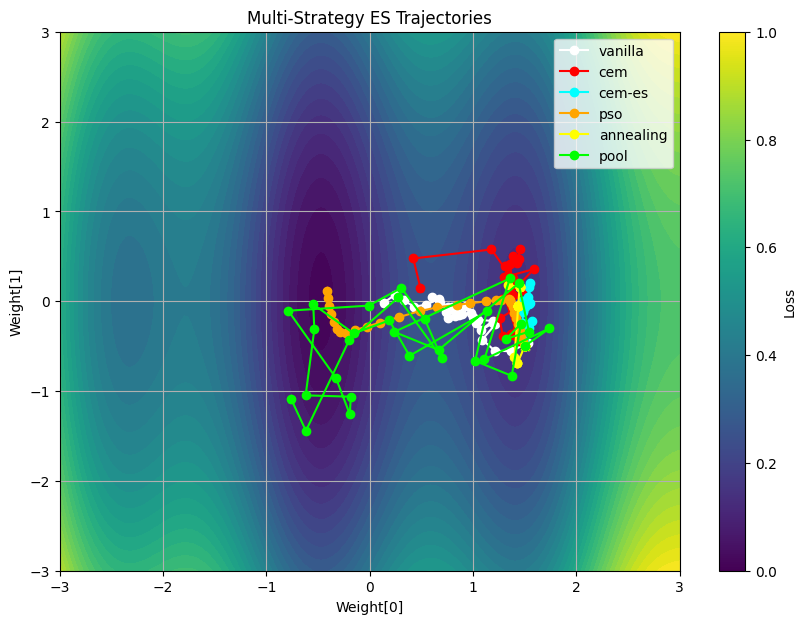

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LightweightESModel:
    def __init__(self, init_mean, param_std=0.05, lr=0.01):
        self.mean = init_mean.clone().detach()
        self.mean.requires_grad = False
        self.param_std = param_std
        self.lr = lr
        self.optimizer = optim.SGD([self.mean], lr=self.lr)
        self.velocity = torch.zeros_like(self.mean)
        self.personal_best = self.mean.clone()
        self.global_best = self.mean.clone()
        self.best_loss = float('inf')
        self.mean_trace = [self.mean.clone()]

    def sample(self, n):
        self.samples = torch.normal(mean=self.mean.expand(n, -1), std=self.param_std)
        return self.samples

    def step(self, losses, method="vanilla"):
        if method == "vanilla":
            log_grad = (self.samples - self.mean) / self.param_std**2
            norm_loss = (losses - losses.mean()) / (losses.std() + 1e-8)
            grad = (log_grad.T * norm_loss).T.mean(dim=0)
            self.mean.grad = grad
            self.optimizer.step()

        elif method == "cem":
            k = max(1, int(0.2 * len(losses)))
            top_idx = torch.argsort(losses)[:k]
            self.mean = self.samples[top_idx].mean(dim=0).detach()

        elif method == "cem-es":
            k = max(1, int(0.2 * len(losses)))
            top_idx = torch.argsort(losses)[:k]
            elite = self.samples[top_idx]
            elite_losses = losses[top_idx]
            log_grad = (elite - self.mean) / self.param_std**2
            norm_loss = (elite_losses - elite_losses.mean()) / (elite_losses.std() + 1e-8)
            grad = (log_grad.T * norm_loss).T.mean(dim=0)
            self.mean.grad = grad
            self.optimizer.step()

        elif method == "pso":
            best_idx = torch.argmin(losses)
            if losses[best_idx] < self.best_loss:
                self.best_loss = losses[best_idx].item()
                self.global_best = self.samples[best_idx].detach()
            r1, r2 = torch.rand(2)
            self.velocity = 0.5 * self.velocity \
                            + 1.5 * r1 * (self.personal_best - self.mean) \
                            + 1.5 * r2 * (self.global_best - self.mean)
            self.mean = self.mean + self.lr * self.velocity
            self.personal_best = self.mean.clone()

        elif method == "annealing":
            T = max(0.01, torch.exp(torch.tensor(-0.1 * len(self.mean_trace))))
            proposal = self.mean + torch.randn_like(self.mean) * self.param_std
            loss_new = loss_fn(proposal.unsqueeze(0))[0]
            loss_old = loss_fn(self.mean.unsqueeze(0))[0]
            prob = torch.exp(-(loss_new - loss_old) / T)
            if loss_new < loss_old or torch.rand(1) < prob:
                self.mean = proposal.detach()

        elif method == "pool":
            parent_size = max(2, int(0.4 * len(self.samples)))
            parent = self.samples[:parent_size]
            offspring = parent + torch.randn_like(parent) * self.param_std
            losses_offspring = loss_fn(offspring)
            top_idx = torch.argsort(losses_offspring)[:max(1, parent_size // 2)]
            self.mean = offspring[top_idx].mean(dim=0).detach()

        self.mean_trace.append(self.mean.clone())


# 2D loss landscape function
def loss_fn(x):
    return x[:, 0]**2 + 0.5 * x[:, 1]**2 + 2 * torch.sin(3 * x[:, 0])

# Compare multiple strategies
def compare_strategies(strategies, steps=30, samples=10, init=torch.tensor([1.5, -0.5]), std=0.5, lr=0.1):
    x = np.linspace(-3, 3, 200)
    y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 0.5 * Y**2 + 2 * np.sin(3 * X)

    colors = ["white", "red", "cyan", "orange", "yellow", "lime"]
    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')

    for method, color in zip(strategies, colors):
        model = LightweightESModel(init_mean=init, param_std=std, lr=lr)
        for _ in range(steps):
            s = model.sample(samples)
            l = loss_fn(s)
            model.step(l, method=method)
        trace = torch.stack(model.mean_trace).numpy()
        plt.plot(trace[:, 0], trace[:, 1], marker='o', label=method, color=color)
        plt.scatter(trace[0, 0], trace[0, 1], color=color, marker='x')
        plt.scatter(trace[-1, 0], trace[-1, 1], color=color, marker='*')

    plt.title("Multi-Strategy ES Trajectories")
    plt.xlabel("Weight[0]")
    plt.ylabel("Weight[1]")
    plt.legend()
    plt.colorbar(label="Loss")
    plt.grid(True)
    plt.show()

# Example call:
compare_strategies(["vanilla", "cem", "cem-es", "pso", "annealing", "pool"])

Hybrid Evolution

<ipython-input-268-185e055ae467>:71: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(trace[0, 0], trace[0, 1], marker='x', color='white', edgecolor='black', s=100, label='Start', zorder=5)


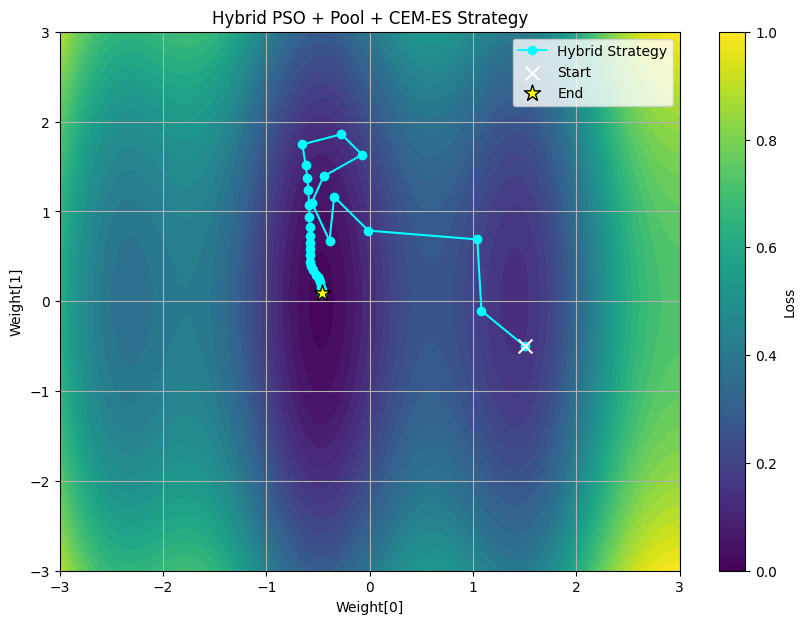

In [268]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 2D loss landscape function
def loss_fn(x):
    return x[:, 0]**2 + 0.5 * x[:, 1]**2 + 2 * torch.sin(3 * x[:, 0])

# PSO + μ+λ Pool + CEM-ES hybrid
def hybrid_es_strategy(steps=30, samples=10, pool_cutoff = 10, switch_es=30, init=torch.tensor([1.5, -0.5]), std=0.5, lr=0.1):
    mean = init.clone().detach()
    velocity = torch.zeros_like(mean)
    personal_best = mean.clone()
    global_best = mean.clone()
    best_loss = float('inf')
    mean_trace = [mean.clone()]

    for t in range(steps):
        # Sampling
        sample_batch = torch.normal(mean.expand(samples, -1), std=std)
        losses = loss_fn(sample_batch)

        if t < switch_es:
            # PSO-inspired + μ+λ Pool
            best_idx = torch.argmin(losses)
            if losses[best_idx] < best_loss:
                best_loss = losses[best_idx].item()
                global_best = sample_batch[best_idx].detach()

            # PSO-inspired update
            r1, r2 = torch.rand(2)
            velocity = 0.5 * velocity + 1.5 * r1 * (personal_best - mean) + 1.5 * r2 * (global_best - mean)
            mean = mean + lr * velocity
            personal_best = mean.clone()

            if t < pool_cutoff:
              # μ+λ Pool update
              parent_size = int(0.4 * samples)
              parent = sample_batch[:parent_size]
              offspring = parent + torch.randn_like(parent) * std
              offspring_losses = loss_fn(offspring)
              top_idx = torch.argsort(offspring_losses)[:max(1, parent_size // 2)]
              mean = offspring[top_idx].mean(dim=0).detach()

        else:
            # CEM-ES refinement
            k = max(1, int(0.2 * samples))
            top_idx = torch.argsort(losses)[:k]
            elite = sample_batch[top_idx]
            elite_losses = losses[top_idx]
            log_grad = (elite - mean) / std**2
            norm_loss = (elite_losses - elite_losses.mean()) / (elite_losses.std() + 1e-8)
            grad = (log_grad.T * norm_loss).T.mean(dim=0)
            mean = mean - lr * grad

        mean_trace.append(mean.clone())

    return torch.stack(mean_trace)

# visualization
def visualize_hybrid_trace():
    x = np.linspace(-3, 3, 200)
    y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 0.5 * Y**2 + 2 * np.sin(3 * X)

    trace = hybrid_es_strategy()
    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(trace[:, 0], trace[:, 1], color='cyan', marker='o', label='Hybrid Strategy')
    plt.scatter(trace[0, 0], trace[0, 1], marker='x', color='white', edgecolor='black', s=100, label='Start', zorder=5)
    plt.scatter(trace[-1, 0], trace[-1, 1], marker='*', color='yellow', edgecolor='black', s=150, label='End', zorder=6)
    plt.title("Hybrid PSO + Pool + CEM-ES Strategy")
    plt.xlabel("Weight[0]")
    plt.ylabel("Weight[1]")
    plt.colorbar(label="Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_hybrid_trace()
